# Parallel computing
**Parallel computing** refers to the process of breaking down larger problems into smaller, independent, often similar parts that can be executed simultaneously by multiple processors communicating via network or shared memory, the results of which are combined upon completion as part of an overall algorithm.

## $\pi$ example
We can calculate the value of $\pi$ using a MPI parallelized version of the Monte Carlo method. The basic idea is to estimate $\pi$ by randomly sampling points within a square and determining how many fall inside a quarter circle inscribed within that square.

![PI](https://www.101computing.net/wp/wp-content/uploads/estimating-pi-monte-carlo-method.png)

The ratio between the area of the circle and the square is

$\frac{N_\text{in}}{N_\text{total}} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4}$

Therefore, we can calculate $\pi$ using 
$\pi = \frac{4N_\text{in}}{N_\text{total}} $

KeyboardInterrupt: 

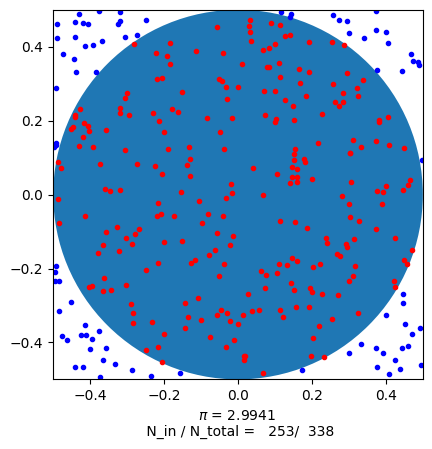

In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import time
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
circle = plt.Circle(( 0. , 0. ), 0.5 )
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.add_patch(circle)
ax.set_aspect('equal')
N = 500
Nin = 0
t0 = time.time()
for i in range(1, N+1):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
        plt.plot([x], [y], 'o', color='r', markersize=3)
    else:
        plt.plot([x], [y], 'o', color='b', markersize=3)
    display(fig)
    plt.xlabel("$\pi$ = %3.4f \n N_in / N_total = %5d/%5d" %(Nin*4.0/i, Nin, i))
    clear_output(wait=True)

res = np.array(Nin, dtype='d')
t1 = time.time()
print(f"Pi = {res/float(N/4.0)}")
print("Time: %s" %(t1 - t0))

### MPI example
```python
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 5000000
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(Nin, dtype='d')
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank==0:
    print(res_tot/float(N/4.0))
    print("Time: %s" %(t1 - t0))
```

### Running $\pi$ example on Google Colab
* Go to https://colab.research.google.com/, sign in or sign up
* "File"-> "open notebook"
* choose ```01_intro_AI_on_Supercomputer/00_mpi.ipynb``` from the list
![Google Colab](figures/colab.png)

In [2]:
! wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py
! pip install mpi4py

--2024-02-11 21:44:03--  https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/mpi_pi.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... failed: Network is unreachable.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443

In [3]:
! mpirun -np 1 python mpi_pi.py

Number of processes: 1
Pi = 3.1420584
Time: 5.370685


In [4]:
! mpirun -np 2 python mpi_pi.py

Number of processes: 2
Pi = 3.1416024
Time: 3.702421


In [5]:
! mpirun -np 4 python mpi_pi.py

Number of processes: 4
Pi = 3.1419392
Time: 2.140730


### Running $\pi$ on Polaris
```bash
ssh <username>@polaris.alcf.anl.gov
qsub -A ALCFAITP -l select=1 -q ALCFAITP -l walltime=0:30:00 -l filesystems=home:eagle
# choose debug queue outside of the class
# qsub -A ALCFAITP -l select=1 -q debug -l walltime=0:30:00 -l filesystems=home:eagle

module load conda/2023-10-04
conda activate /soft/datascience/ALCFAITP/2023-10-04
git clone git@github.com:argonne-lcf/ai-science-training-series.git
cd ai-science-training-series/01_intro_AI_on_Supercomputer/
mpirun -np 1 python mpi_pi.py   # 3.141988,   8.029037714004517  s
mpirun -np 2 python mpi_pi.py   # 3.1415096   4.212774038314819  s
mpirun -np 4 python mpi_pi.py   # 3.1425632   2.093632459640503  s
mpirun -np 8 python mpi_pi.py   # 3.1411632   1.0610620975494385 s
```

**Attention: Please use ```debug``` queue outside of lecture time instead of ```ALCFAITP```.** 

## Parallel computing in AI
The parallel computing in AI is usually called distributed training. Distributed training is the process of training I models across multiple GPUs or other accelerators, with the goal of speeding up the training process and enabling the training of larger models on larger datasets.

There are two ways of parallelization in distributed training. 
* **Data parallelism**: 
    * Each worker (GPU) has a complete set of model
    * different workers work on different subsets of data. 
* **Model parallelism** 
    * The model is splitted into different parts and stored on different workers
    * Different workers work on computation involved in different parts of the model
![PI](figures/parallel_computing.png)